In [1]:
import sympy as sp
import tensorflow as tf
import tensorflow.python.keras.backend as K
import tensorflow_probability as tfp

import MLGeometry as mlg
from MLGeometry import bihomoNN as bnn

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
tf.random.set_seed(42)

Hello from BihomoNN! Arbitrary dimension!


In [2]:
# Matplotlib options
%matplotlib inline
#%matplotlib notebook
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['text.usetex'] = True

## Modules

In [3]:
# Plot training get_loss_hist
def plot_train_hist(model, val=False, y_scale='linear'):
    x1 = np.arange(1, len(model.get_loss_hist())+1)
    plt.scatter(x1, model.get_loss_hist(), marker='.', label='Training loss' )
    #if val:
    #    plt.scatter(x1, model.get_loss_hist['val_loss'], marker='.', label='Validation loss')
    plt.xlabel('Training epochs')
    plt.ylabel('Loss')
    plt.yscale(y_scale)
    plt.legend()
    print("Final loss: ", model.get_loss_hist()[-1])
    return plt.show()

In [11]:
def cal_total_loss(dataset, hermitian_met, kahler_pot, loss_function, c1):
    total_loss = tf.constant(0, dtype=tf.float32)
    total_mass = tf.constant(0, dtype=tf.float32)
    
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(dataset):
        curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
        mass_sum = tf.reduce_sum(mass)
        total_loss += loss_function(c1, curv_tr, mass)  * mass_sum
        total_mass += mass_sum
    total_loss = total_loss / total_mass

    return total_loss.numpy()



Networks for $\mathcal{O}_X(1)$, $\mathcal{O}_X(2)$, $\mathcal{O}_X(4)$ respectively.

\begin{itemize}
\item "dim" is the number of projective coordinates of points on the CY hypersurface.
\item "vec" is a vector giving the number of neurons for layers 1 through d-1
\item "rank" is the rank of the vector bundle -- so far should just be 1
\end{itemize}

In [5]:
class Hermitian_metric_O1(tf.keras.Model):
    def __init__(self, dim, rank, vec):
        super(Hermitian_metric_O1, self).__init__()
        self.dim = dim
        self.rank = rank
        self.vec = vec
        self.loss_hist = []
        print("Bundle rank", self.rank)
        self.bihomogeneous = bnn.Bihomogeneous(self.dim)
        self.layer1 = bnn.Dense(self.dim**2, self.rank)
    
    def append_loss(self, loss):
        self.loss_hist.append([loss])
    
    def get_loss_hist(self):
        return self.loss_hist
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = tf.math.log(x)
        return x
    

class Hermitian_metric_O2(tf.keras.Model):
    def __init__(self, dim, rank, vec):
        super(Hermitian_metric_O2, self).__init__()
        self.dim = dim
        self.rank = rank
        self.vec = vec
        self.loss_hist = []
        print("Bundle rank", self.rank)
        self.bihomogeneous = bnn.Bihomogeneous(self.dim)
        self.layer1 = bnn.Dense(self.dim**2, self.vec[0], activation=tf.square)
        self.layer2 = bnn.Dense(self.vec[0], self.rank)
        
    def append_loss(self, loss):
        self.loss_hist.append([loss])
    
    def get_loss_hist(self):
        return self.loss_hist
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = tf.math.log(x)
        return x
  

class Hermitian_metric_O4(tf.keras.Model):
    def __init__(self, dim, rank, vec):
        super(Hermitian_metric_O4, self).__init__()
        self.dim = dim
        self.rank = rank
        self.vec = vec
        self.loss_hist = []
        print("Bundle rank", self.rank)
        self.bihomogeneous = bnn.Bihomogeneous(self.dim)
        self.layer1 = bnn.Dense(dim**2, self.vec[0], activation=tf.square)
        self.layer2 = bnn.Dense(self.vec[0], self.vec[1], activation=tf.square)
        self.layer3 = bnn.Dense(self.vec[1], self.rank)
    
    def append_loss(self, loss):
        self.loss_hist.append([loss])
    
    def get_loss_hist(self):
        return self.loss_hist
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = tf.math.log(x)
        return x

## Curvature calculation

\begin{itemize}
\item Issue with normalization needs to be fixed here, in weighted_loss
\item Other issue is taking inverse of K\"ahler metric or curvature tensor when calculating $g^{i\bar{j}} F_{i\bar{j}}$
\end{itemize}

weighted_loss and curvature_trace are used together to determine

\begin{eqnarray}
  \label{eq:error-loss-num}
       E(\vec{\mathbf{w}}) &=&        
       \frac{\sum_{\mathrm{points,} i} \left( g^{i\bar{j}}(p_i) F_{i \bar{j}}(\vec{\mathbf{w}}, p_i ) - \mu(L) \right) w_i ~}{  \sum_{\mathrm{points,} i} w_i } \\
       &:=& \frac{\left( \int_X g^{i\bar{j}} F_{i \bar{j}}(\vec{\mathbf{w}})  - \mu(L)~ \mathrm{dvol_{CY}}\right) }{ \int_X \mathrm{dvol{CY}}} 
\end{eqnarray}


In [6]:
def weighted_MAPE(y_true, y_pred, mass):
    weights = mass / K.sum(mass)
    return K.sum(K.abs(y_true - y_pred) / tf.cast(y_true, tf.float32) * weights)

def weighted_loss(y_true, y_pred, mass):
    weights = mass /K.sum(mass)
    #print(4"loss1:", K.sum( K.abs(y_pred - y_true) * weights))
    #print("loss2:", K.sum( K.abs(y_pred - y_true) * weights) / K.sum(weights))
    #return K.abs( K.sum( (y_pred - y_true) * weights) ) / K.sum(weights) 
    return K.sum( K.abs(y_pred - y_true) * weights) / K.sum(weights)

@tf.function
def curvature_trace(points, kahler_pot, herm_metric, mass):
    kahler_metric = mlg.complex_math.complex_hessian(tf.math.real(kahler_pot(points)), points)
    #print("kahler_metric: ", kahler_metric)
    #inv_kahler_metric = tf.linalg.inv(kahler_metric)
    #print("inverse kahler_metric: ", inv_kahler_metric)
    curvature = mlg.complex_math.complex_hessian(tf.math.real(herm_metric(points)), points)
    #print("curvature", curvature)
    #inv_curvature = tf.linalg.inv(curvature)
    curvature_trace = tf.linalg.trace(tf.matmul(kahler_metric, curvature) )
    # print("contraction", tf.matmul(kahler_metric, curvature) )
    # print("curvature_trace: ", curvature_trace)
    return curvature_trace


## Generate points and load Kahler potential network

In [7]:
z0, z1, z2 = sp.symbols('z0, z1, z2')
Z = [z0, z1, z2]
a, b =  -1, 1
f = z0**3 + a * (z0**2)*z2 - (z1**2)*z2 + b*(z2**3) 
#f = z0**3 + z1**3 + z2**3 # Switch to Fermat curve
f

z0**3 - z0**2*z2 - z1**2*z2 + z2**3

In [8]:
# Create training and testing set
n_pairs = 10000
HS_train = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
HS_test = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
train_set = mlg.tf_dataset.generate_dataset(HS_train)
test_set = mlg.tf_dataset.generate_dataset(HS_test)
train_set = train_set.shuffle(HS_train.n_points).batch(1000)
test_set = test_set.shuffle(HS_test.n_points).batch(1000)

In [9]:
# Load CY metric/Kahler potential
kahler_pot = tf.keras.models.load_model("ec_2_kahler_pot")
# kahler_pot = tf.keras.models.load_model("ec_fermat_kahler_pot") # Switch to fermat curve

## O(1)

This has stopped working due to no gradients occuring - $\mathcal{O}_X(2)$ is the first that works

In [76]:
# Define and train model for hermitian metric
hermitian_met = Hermitian_metric_O1(3, 1, [])
print("Hermitian metric G network defined")
c1 = tf.constant(1., shape=(1000), dtype=tf.complex64)
optimizer = tf.keras.optimizers.Adam()
loss_func = weighted_MAPE 
loss_hist = []
max_epochs = 100 
epoch = 0
#print("Beginning training")
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        with tf.GradientTape() as tape:
            # det_omega = nf.volume_form(points, Omega_Omegabar, mass, restriction, kahler_pot)
            curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
            #print("calculate curv_tr: ", curv_tr)
            #print("c1: ", c1)
            loss = loss_func(curv_tr, c1, mass)
            grads = tape.gradient(loss, hermitian_met.trainable_weights)
        optimizer.apply_gradients(zip(grads, hermitian_met.trainable_weights))
    #if epoch % 50 == 0:
    #    print("epoch %d: loss = %.7f" % (epoch, loss))
    loss_hist.append(loss)
    hermitian_met.append_loss(loss)
    print("epoch %d: loss = %.7f" % (epoch, loss))

Bundle rank 1
Hermitian metric G network defined


ValueError: No gradients provided for any variable: ['Variable:0'].

Final loss:  ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=2122.4229>])


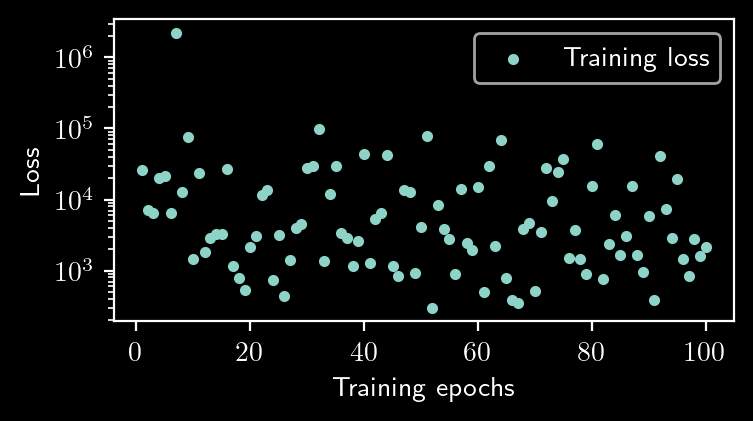

In [22]:
plot_train_hist(hermitian_met, y_scale='log')

## O(2) -- 2 layer network

Trains well, but performance seems random -- should run for longer, e.g. 500 or 1000 rounds

In [78]:
# Define and train model for hermitian metric
hermitian_met = Hermitian_metric_O2(3, 1, [100])
print("Hermitian metric G network defined")
c1 = tf.constant(2., shape=(1000), dtype=tf.complex64)
optimizer = tf.keras.optimizers.Adam()
loss_func = weighted_loss  
loss_hist = []
max_epochs = 100 
epoch = 0
#print("Beginning training")
while epoch < max_epochs:
    epoch = epoch + 1
    # print("epoch: ", epoch)
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        # print("mass: ", mass)
        with tf.GradientTape() as tape:
            curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
            loss = loss_func(c1, curv_tr, mass) 
            grads = tape.gradient(loss, hermitian_met.trainable_weights)
        optimizer.apply_gradients(zip(grads, hermitian_met.trainable_weights))
    #if epoch % 50 == 0:
    #    print("epoch %d: loss = %.7f" % (epoch, loss))
    loss_hist.append(loss)
    hermitian_met.append_loss(loss)
    print("epoch %d: loss = %.7f" % (epoch, loss))

Bundle rank 1
Hermitian metric G network defined
epoch 1: loss = 0.4152077
epoch 2: loss = 0.2462641
epoch 3: loss = 0.2157634
epoch 4: loss = 0.2029460
epoch 5: loss = 0.1592798
epoch 6: loss = 0.1958732
epoch 7: loss = 0.1837285
epoch 8: loss = 0.1640707
epoch 9: loss = 0.1950198
epoch 10: loss = 0.1634691
epoch 11: loss = 0.1747584
epoch 12: loss = 0.1678677
epoch 13: loss = 0.1574437
epoch 14: loss = 0.2061749
epoch 15: loss = 0.1732367
epoch 16: loss = 0.1668803
epoch 17: loss = 0.1582795
epoch 18: loss = 0.1635014
epoch 19: loss = 0.1616841
epoch 20: loss = 0.1654822
epoch 21: loss = 0.1670287
epoch 22: loss = 0.1636321
epoch 23: loss = 0.1820322
epoch 24: loss = 0.1637284
epoch 25: loss = 0.1720325
epoch 26: loss = 0.1514293
epoch 27: loss = 0.1605239
epoch 28: loss = 0.1696578
epoch 29: loss = 0.1583610
epoch 30: loss = 0.1473488
epoch 31: loss = 0.1604525
epoch 32: loss = 0.1580834
epoch 33: loss = 0.1633692
epoch 34: loss = 0.1609171
epoch 35: loss = 0.1836044
epoch 36: loss 

Final loss:  ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=0.15753059>])


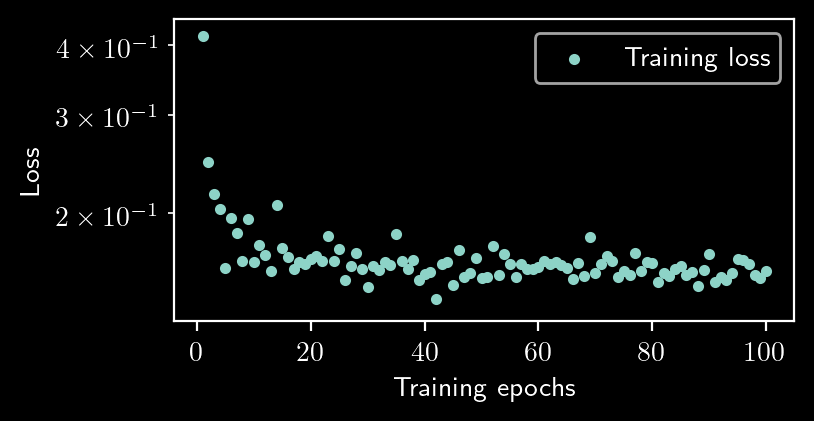

In [79]:
plot_train_hist(hermitian_met, y_scale='log')

Validation/test data

In [85]:
cal_total_loss(test_set, hermitian_met, kahler_pot, weighted_loss, c1)

0.15755129

## O(4) -- 3 layer network

Seems to train reasonably well compared to the others, 

In [87]:
# Define and train model for hermitian metric
hermitian_met = Hermitian_metric_O4(3, 1, [10,100])
print("Hermitian metric G network defined")
c1 = tf.constant(4., shape=(1000), dtype=tf.complex64)
optimizer = tf.keras.optimizers.Adam()
loss_func = weighted_loss 
max_epochs = 100 
epoch = 0
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        with tf.GradientTape() as tape:
            curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
            #print("calculate curv_tr: ", curv_tr)
            #print("c1: ", c1)
            loss = loss_func(c1, curv_tr, mass) 
            # print("calculated loss: ", loss)
            grads = tape.gradient(loss, hermitian_met.trainable_weights)
        optimizer.apply_gradients(zip(grads, hermitian_met.trainable_weights))
    #if epoch % 50 == 0:
    #    print("epoch %d: loss = %.7f" % (epoch, loss))
    hermitian_met.append_loss(loss)
    print("epoch %d: loss = %.7f" % (epoch, loss))

Bundle rank 1
Hermitian metric G network defined
epoch 1: loss = 16.1619701
epoch 2: loss = 16.0926819
epoch 3: loss = 15.7837143
epoch 4: loss = 15.8820648
epoch 5: loss = 15.2283545
epoch 6: loss = 13.9912577
epoch 7: loss = 14.4588242
epoch 8: loss = 14.9011517
epoch 9: loss = 12.0699596
epoch 10: loss = 10.6898298
epoch 11: loss = 9.9705009
epoch 12: loss = 9.4152222
epoch 13: loss = 8.1927567
epoch 14: loss = 8.4536619
epoch 15: loss = 7.7269716
epoch 16: loss = 7.8843541
epoch 17: loss = 7.1163778
epoch 18: loss = 7.0020380
epoch 19: loss = 6.8990512
epoch 20: loss = 6.7431631
epoch 21: loss = 6.5468512
epoch 22: loss = 6.4904361
epoch 23: loss = 6.3272471
epoch 24: loss = 5.8370357
epoch 25: loss = 5.7695532
epoch 26: loss = 5.4734135
epoch 27: loss = 5.4484863
epoch 28: loss = 5.5860062
epoch 29: loss = 5.5218549
epoch 30: loss = 4.9923086
epoch 31: loss = 5.1361675
epoch 32: loss = 5.0360775
epoch 33: loss = 4.6790938
epoch 34: loss = 4.6885009
epoch 35: loss = 4.9743395
epoch

Final loss:  ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.8780022>])


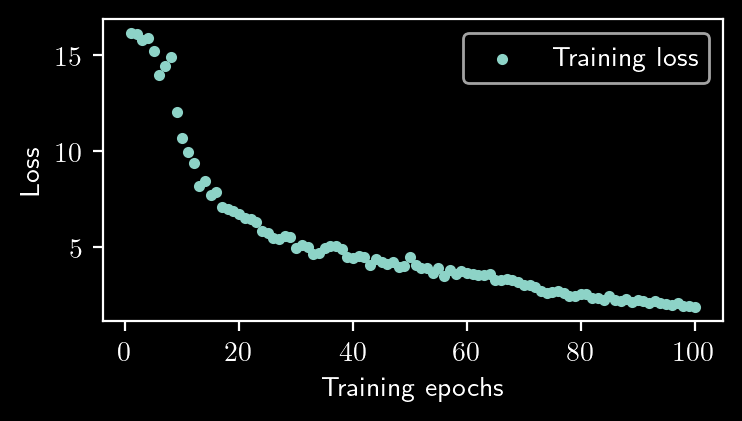

In [88]:
plot_train_hist(hermitian_met, y_scale='linear')

Run this again and see:

In [10]:
# Define and train model for hermitian metric
hermitian_met = Hermitian_metric_O4(3, 1, [10,100])
print("Hermitian metric G network defined")
c1 = tf.constant(4., shape=(1000), dtype=tf.complex64)
optimizer = tf.keras.optimizers.Adam()
loss_func = weighted_loss 
max_epochs = 100 
epoch = 0
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        with tf.GradientTape() as tape:
            curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
            #print("calculate curv_tr: ", curv_tr)
            #print("c1: ", c1)
            loss = loss_func(c1, curv_tr, mass) 
            # print("calculated loss: ", loss)
            grads = tape.gradient(loss, hermitian_met.trainable_weights)
        optimizer.apply_gradients(zip(grads, hermitian_met.trainable_weights))
    #if epoch % 50 == 0:
    #    print("epoch %d: loss = %.7f" % (epoch, loss))
    hermitian_met.append_loss(loss)
    print("epoch %d: loss = %.7f" % (epoch, loss))

Bundle rank 1
Hermitian metric G network defined


/home/rehandeen/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


epoch 1: loss = 5.9414091
epoch 2: loss = 2.9912207
epoch 3: loss = 1.9286295
epoch 4: loss = 1.4754308
epoch 5: loss = 1.1345481
epoch 6: loss = 0.8580085
epoch 7: loss = 0.6426318
epoch 8: loss = 0.5624699
epoch 9: loss = 0.4555495
epoch 10: loss = 0.4347323
epoch 11: loss = 0.3900386
epoch 12: loss = 0.3674594
epoch 13: loss = 0.3561155
epoch 14: loss = 0.3214222
epoch 15: loss = 0.3165632
epoch 16: loss = 0.3131433
epoch 17: loss = 0.2853901
epoch 18: loss = 0.2570019
epoch 19: loss = 0.2776822
epoch 20: loss = 0.2827359
epoch 21: loss = 0.2617073
epoch 22: loss = 0.2341670
epoch 23: loss = 0.2547054
epoch 24: loss = 0.2430686
epoch 25: loss = 0.2345116
epoch 26: loss = 0.2305654
epoch 27: loss = 0.2142126
epoch 28: loss = 0.2433473
epoch 29: loss = 0.2244129
epoch 30: loss = 0.2143625
epoch 31: loss = 0.2179560
epoch 32: loss = 0.2081591
epoch 33: loss = 0.1982332
epoch 34: loss = 0.1954504
epoch 35: loss = 0.2131920
epoch 36: loss = 0.2015739
epoch 37: loss = 0.2305093
epoch 38: 

Final loss:  ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=0.176796>])


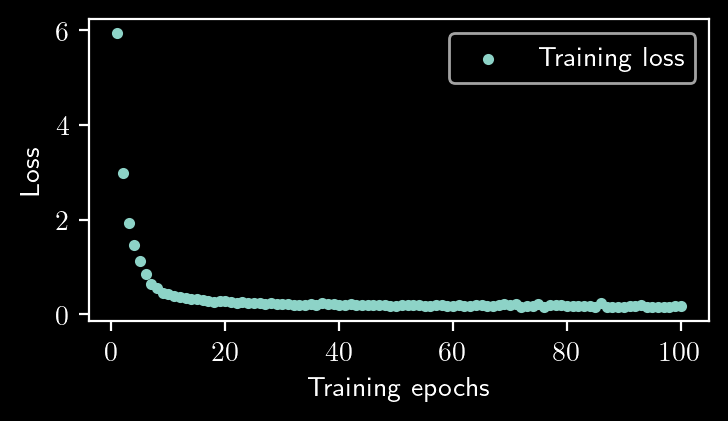

In [12]:
plot_train_hist(hermitian_met, y_scale='linear')

Validation/test data

In [16]:
cal_total_loss(test_set, hermitian_met, kahler_pot, weighted_loss, c1)

0.17504025